In [1]:
# Using Pytorch for Acceleration
import numpy as np
import pandas as pd
import torch
import pandas_market_calendars as mcal
from typing import Optional

# Set device to GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def get_trade_calendar(start_date, end_date) -> pd.DataFrame:
    sse = mcal.get_calendar('SSE')
    cal = pd.DataFrame(pd.date_range(start=start_date, end=end_date, freq='D'), columns=['date'])
    holidays = list(sse.holidays().holidays)
    holidays = [day for day in holidays if (day >= start_date) & (day <= end_date)]
    bus_date = pd.bdate_range(start=start_date, end=end_date, freq='B')
    cal['is_open'] = cal['date'].apply(lambda x: False if x in holidays or x not in bus_date else True)
    return cal

def calc_payoff(cal:pd.DataFrame, # Date data
                vd=0,             # Days from initial date to valuation date
                S0=1,             # Initial price of the underlying asset
                vd_price=1,       # Price of the underlying asset on the valuation date
                M=300000,         # Number of Monte Carlo simulations
                T=1,              # Time step
                q=0.065,          # Continuous dividend yield assumption
                r=0.015,          # Risk-free rate assumption
                sigma=0.15,       # Volatility assumption of the underlying asset
                k_in_price=0.85,  # Knock-in price setting
                k_coupon=0.2,     # Knock-out coupon assumption
                d_coupon=0.2,     # Maturity coupon assumption if not knocked out
                Z=None,           # Standard normal distribution
                ) -> float:
    
    torch.manual_seed(38)
    
    dt = T / cal[cal['is_open'] == 1]['date'].count()
    residual_days = cal[vd:]
    trading_days = residual_days[residual_days['is_open'] == 1].index
    N = len(trading_days) - 1
    
    if Z is None:
        Z = torch.randn(N, M, device=device)
    
    delta_st = (r - q - 0.5 * sigma ** 2) * dt + sigma * torch.sqrt(torch.tensor(dt, device=device)) * Z
    delta_st = torch.cat([torch.zeros((1, M), device=device), delta_st], dim=0)
    st = torch.cumprod(torch.exp(delta_st), dim=0) * torch.tensor(vd_price, device=device)
    st_df = pd.DataFrame(st.cpu().numpy(), index=trading_days)
    
    kout_days = residual_days[residual_days['monitor'] == 1].index
    kout_days = [day for day in kout_days if day in st_df.index]  # Check and filter dates
    if not kout_days:
        return 0.0  # Return 0 if there are no knock-out days
    
    kout = np.tile(kout_days, (M, 1)).T
    kout = np.where(st_df.loc[kout_days].gt(cal.loc[kout_days, 'B_out'], axis=0), kout, np.inf)
    kout_date = np.min(kout, axis=0)
    
    kin = torch.any(st < k_in_price, dim=0)
    
    kout_date_tensor = torch.tensor(kout_date, device=device, dtype=torch.float32)
    pnl_kout = torch.sum(kout_date_tensor[kout_date_tensor != np.inf] / 365 * k_coupon * torch.exp(-r * kout_date_tensor[kout_date_tensor != np.inf] / 365))
    pnl_htm = torch.sum(((kout_date_tensor == np.inf) & (kin == False)).float()) * d_coupon * torch.exp(-torch.tensor(r * T, device=device))
    pnl_loss = torch.sum((st[-1, (kout_date_tensor == np.inf) & kin & (st[-1] < S0)] / S0 - 1) * torch.exp(-torch.tensor(r * T, device=device)))
    V = (pnl_htm + pnl_kout + pnl_loss) / M
    
    return V.item()

def simulate(underlying:str,                               # Contract name
             initial_price:float,                          # Initial price of the underlying asset
             start_date:str,                               # Contract start date
             end_date:str,                                 # Contract end date
             monitor:list,                                 # Knock-out observation days
             r:float,                                      # Risk-free rate assumption
             capital:float,                                # Notional principal
             k_coupon:float,                               # Knock-out coupon assumption
             k_in_ratio:float,                             # Knock-in ratio
             k_out_ratios:list,                            # Knock-out ratios
             k_out_prices:Optional[float] = None,          # Knock-out prices
             k_in_price:Optional[float] = None,            # Knock-in price
             d_coupon:Optional[float] = None,              # Maturity coupon assumption if not knocked out
             vd_price:Optional[float] = None,              # Price of the underlying asset on the valuation date
             vd_date:Optional[str] = None,                 # Valuation date
             margin_ratio:float = 1,                       # Margin ratio
             M = 300000,                                   # Number of Monte Carlo simulations
             unit=True,
             **kwargs): 
    
    if monitor[-1] != end_date:
        end_date = monitor[-1]
    
    if k_out_prices is not None:
        assert len(monitor) == len(k_out_prices), 'knock out prices and knock out days are not at same length'
    assert isinstance(k_out_prices, list), 'knock out prices should be list'
    
    if k_in_price is None:
        k_in_price = initial_price * k_in_ratio
    
    if vd_price is None:
        vd_price = initial_price
        
    if d_coupon is None:
        d_coupon = k_coupon
    
    st_dt = pd.to_datetime(start_date)
    ed_dt = pd.to_datetime(end_date)
    T = (ed_dt - st_dt).days / 365
    
    cal = get_trade_calendar(start_date=st_dt, end_date=ed_dt)
    monitor_idx = cal[cal['date'].isin(list(map(pd.to_datetime, monitor)))].index
    cal['monitor'] = np.nan
    cal['B_out'] = np.nan
    cal.loc[monitor_idx, 'monitor'] = 1
    cal.loc[monitor_idx, 'B_out'] = k_out_prices
    
    if vd_date is None:
        vd = 0
    else:
        vd = (pd.to_datetime(vd_date) - st_dt).days
    
    v = calc_payoff(cal=cal, vd=vd, S0=initial_price, vd_price=vd_price, r=r, M=M, T=T, k_in_price=k_in_price, 
                    k_coupon=k_coupon, d_coupon=d_coupon, **kwargs)
    
    if unit:
        return v
    
    return (v + margin_ratio * torch.exp(torch.tensor(r * vd / 365, device=device))) * margin_ratio * capital * torch.exp(torch.tensor(r * vd / 365, device=device))

# Define function to calculate theoretical coupon
def calculate_theoretical_coupon(params, target_value=0):
    def payoff_with_coupon(coupon_rate): # Define internal function to calculate payoff with given coupon
        local_params = params.copy() # Copy parameters
        local_params['k_coupon'] = coupon_rate # Set current coupon rate
        return simulate(**local_params) # Return simulation result
    
    # Binary search to find theoretical coupon
    low, high = 0, 1
    while high - low > 1e-5:
        mid = (low + high) / 2
        if payoff_with_coupon(mid) > target_value:
            high = mid
        else:
            low = mid
    
    return (low + high) / 2 # Return theoretical coupon

# Parameter configuration
params=dict(
    underlying='CSI500 ABRC',                   # Contract name
    initial_price = 5400,                       # Initial price of the underlying asset
    start_date = '20240102',                    # Contract start date
    end_date = '20251231',                      # Contract end date
    vd_date = None,                             # Valuation date
    monitor=['20240430','20240531','20240628',  # Knock-out observation days
             '20240731','20240830','20240930',
             '20241031','20241129','20241231',
             '20250127','20250228','20250331',
             '20250430','20250530','20250630',
             '20250731','20250829','20250930',
             '20251031','20251128','20251231'],
                                  
    k_out_ratios=[1.03] * 21,                   # Knock-out ratios, length must be the same as observation days
    k_out_prices=[5400 * 1.03] * 21,            # Knock-out prices
    k_coupon=0.20,                              # Knock-out coupon assumption
    capital=1,                                  # Notional principal: 1 million
    margin_ratio=1,                             # Margin ratio
    k_in_ratio=0.75,                            # Knock-in ratio
    sigma=0.14,                                 # Volatility assumption of the underlying asset, annualized over the past 3 months
    q=0.063,                                    # Continuous dividend yield assumption
    r=0.015,                                    # Risk-free rate assumption, based on 1-year government bond
)

# Calculate theoretical coupon
theoretical_coupon = calculate_theoretical_coupon(params)
print(f"Theoretical Coupon Rate: {theoretical_coupon}")


cpu
Theoretical Coupon Rate: 0.12718582153320312


In [2]:
## BTC Net Value Snowball Parameters

# Parameter Configuration
params = dict(
    underlying='BTC ABRC',                      # Contract Name
    initial_price = 65000,                      # Initial Price of the Underlying Asset
    start_date = '20240102',                    # Contract Start Date
    end_date = '20251231',                      # Contract Maturity Date
    vd_date = None,                             # Valuation Date
    monitor=['20240430','20240531','20240628',  # Knock-out Observation Dates
             '20240731','20240830','20240930',
             '20241031','20241129','20241231',
             '20250127','20250228','20250331',
             '20250430','20250530','20250630',
             '20250731','20250829','20250930',
             '20251031','20251128','20251231'],
                                  
    k_out_ratios=[1.03] * 21,                   # Knock-out Ratios, length must match observation dates
    k_out_prices=[65000 * 1.03] * 21,           # Knock-out Prices
    k_coupon=0.20,                              # Assumed Knock-out Coupon Rate
    capital=1,                                  # Nominal Principal: 1 million
    margin_ratio=1,                             # Margin Ratio
    k_in_ratio=0.75,                            # Knock-in Ratio
    sigma=0.50,                                 # Assumed Volatility of the Underlying, annualized over the past 3 months
    q=0.063,                                    # Assumed Continuous Dividend Yield
    r=0.015,                                    # Assumed Risk-Free Rate, based on 1Y Treasury bond
)

# Calculate Theoretical Coupon
theoretical_coupon = calculate_theoretical_coupon(params)
print(f"Theoretical Coupon Rate: {theoretical_coupon}")


Theoretical Coupon Rate: 0.4711036682128906


In [2]:
# Test 500 Snowball Theoretical Pricing
params = dict(
    underlying='CSI500 ABRC',                   # Contract name
    initial_price = 5400,                       # Initial price of underlying asset
    start_date = '20240102',                    # Contract start date
    end_date = '20251231',                      # Contract expiration date
    vd_date = None,                             # Valuation date
    monitor = ['20240430', '20240531', '20240628',  # Knock-out observation dates
               '20240731', '20240830', '20240930',
               '20241031', '20241129', '20241231',
               '20250127', '20250228', '20250331',
               '20250430', '20250530', '20250630',
               '20250731', '20250829', '20250930',
               '20251031', '20251128', '20251231'],
                                  
    k_out_ratios = [1.03] * 21,                 # Knock-out ratio, length should be the same as observation dates
    k_out_prices = [5400 * 1.03] * 21,          # Knock-out price
    k_coupon = 0.20,                            # Knock-out coupon assumption
    capital = 1,                                # Nominal principal: 1 million yuan
    margin_ratio = 1,                           # Margin ratio
    k_in_ratio = 0.75,                          # Knock-in ratio
    sigma = 0.14,                               # Underlying volatility assumption, annualized for the past 3 months
    q = 0.063,                                  # Continuous dividend yield assumption
    r = 0.015,                                  # Risk-free rate assumption, using 1Y active government bond
)

v = simulate(**params)
v


0.037391528487205505

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:17<00:00,  2.58s/it]


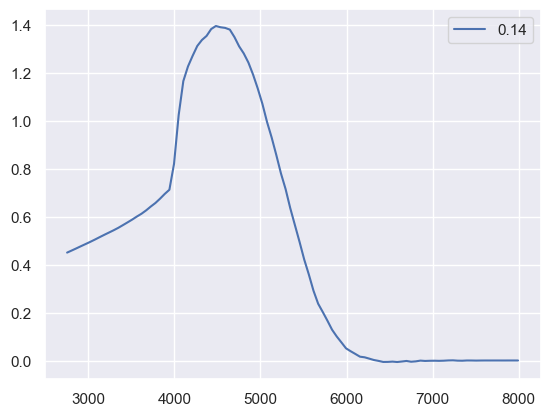

In [4]:
## Solve Dynamic Delta

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import copy
sns.set_theme()

sigma_lst = [0.14]
payoffs, delta, gamma, vega, rho, theta = dict(), dict(), dict(), dict(), dict(), dict()
for sigma in sigma_lst:
    payoffs[sigma], delta[sigma], gamma[sigma], vega[sigma], rho[sigma], theta[sigma] = dict(), dict(), dict(), dict(), dict(), dict()
    for vd_price in tqdm(np.arange(2700, 8100, 54)):
        p = dict(sigma=sigma, vd_price=vd_price)
        params.update(p)
        payoffs[sigma][vd_price] = simulate(**params)

for sigma in sigma_lst:
    for vd_price in np.arange(2754, 8046, 54):
        delta[sigma][vd_price] = (payoffs[sigma][vd_price+54] - payoffs[sigma][vd_price-54]) / (108 / vd_price)
for sigma in sigma_lst:
    plt.plot(list(delta[sigma].keys()), list(delta[sigma].values()))
plt.legend(sigma_lst)
plt.show()
